In [1]:
import pandas as pd
import swifter
# import modin.pandas as md
# swifter.register_modin()

import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import time

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [2]:
%%time
df= pd.read_excel("obs_asigna_osee.xlsx", nrows=2000)
print(df.shape)
df.head()

(2000, 5)
Wall time: 8.72 s


,CODIGO_MODULAR,SERIE_EQUIPO_OSEE,obs,flg_cat,flg_bin
0,200022,T0000000001,"Ninguna, esta operativa.",97,1
1,200220,T0000000002,La niña vive con su abuela Aurelia Costilla Fl...,6,1
2,200238,T0000000003,Se asignó la tableta a la estudiante pero aún ...,14,0
3,200220,T0000000004,La Madre vive en Anexo y no pudo actualizar su...,1,0
4,200220,T0000000005,La madre vive en Anexo con la Estudiante y no ...,1,0


# 1. Clean Data

## 1.1. Del StopWords

In [3]:
import spacy
spacy.prefer_gpu()
spacy.cli.download('es_core_news_md')
nlp = spacy.load('es_core_news_md')

#Añadiendo nuevos stopwords
#==========================
sw_nuevos = ['rt','tv','https','mineduperu','ja','q','xd', 'iberio','iberia','iberica','jaja','jajajaja','http', 'click', 'clase','ano','escolar', 'a', 'y','el','la','los','las']
for sw in sw_nuevos:
    nlp.Defaults.stop_words.add(sw)
    nlp.vocab[sw].is_stop = True
nlp.vocab['no'].is_stop = False
nlp.vocab['aun'].is_stop = False

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [4]:
#Eliminando Sw x defecto y personalizados
#========================================

def QuitarSwTodos(tokens):
    doc = nlp(str(tokens).upper())
    final_doc =[]
    for word in doc:
        if word.is_stop==False & word.is_punct==False :
            final_doc.append(word)      
    
    n_tokens = final_doc

    #n_tokens = [token.text for token in doc if not token.is_stop]
    #n_tokens = [token.text for token in doc if not token.is_punct]   

    #lematizando
    #==========    
    cad = ' '.join([str(item) for item in n_tokens])  
    doc = nlp(cad)
    lemas = [tok.lemma_.lower() for tok in doc]
    cad = ' '.join([str(item) for item in lemas])  
    # print('cad',cad) 
    # print('lemas',lemas) 
    return cad

In [5]:
df['oracion_final_str'] = df['obs'].swifter.apply(lambda x: QuitarSwTodos(x))
print(df.shape)
df.head()

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

(2000, 6)


,CODIGO_MODULAR,SERIE_EQUIPO_OSEE,obs,flg_cat,flg_bin,oracion_final_str
0,200022,T0000000001,"Ninguna, esta operativa.",97,1,", operativa ."
1,200220,T0000000002,La niña vive con su abuela Aurelia Costilla Fl...,6,1,"niña vive abuela aurelia costilla flores , dni..."
2,200238,T0000000003,Se asignó la tableta a la estudiante pero aún ...,14,0,"asignó tableta estudiante entregó , estudiante..."
3,200220,T0000000004,La Madre vive en Anexo y no pudo actualizar su...,1,0,"madre vive anexo actualizar dni . 31541124 , m..."
4,200220,T0000000005,La madre vive en Anexo con la Estudiante y no ...,1,0,madre vive anexo estudiante validó dni . 80163...


## 1.2. Speller

In [6]:
from spellchecker import SpellChecker
import re

spellsp = SpellChecker(language='es', distance=1, case_sensitive= False)

In [7]:
def clean_html(html):
        # First we remove inline JavaScript/CSS:
    cleaned = re.sub(r"(?is)<(script|style).*?>.*?(</\1>)", "", html.strip())
    # Then we remove html comments. This has to be done before removing regular
    # tags since comments can contain '>' characters.
    cleaned = re.sub(r"(?s)<!--(.*?)-->[\n]?", "", cleaned)
    # Next we can remove the remaining tags:
    cleaned = re.sub(r"(?s)<.*?>", " ", cleaned)
    # Finally, we deal with whitespace
    cleaned = re.sub(r"&nbsp;", " ", cleaned)
    cleaned = re.sub(r"[\r\n]", " ", cleaned)
    cleaned = re.sub(r"[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", " ", cleaned)
    cleaned = re.sub(r"  ", " ", cleaned)    
    return cleaned.strip()
    raise NotImplementedError ("To remove HTML markup, use BeautifulSoup's get_text() function")
df['oracion_final_str'] = df.oracion_final_str.swifter.apply(lambda oracion: clean_html(str(oracion).lower()))
df['oracion_final_str'] = df.oracion_final_str.swifter.apply(lambda oracion: re.findall('[a-zA-ZáéíóúüÑñ]+', oracion))

df['length'] = df.oracion_final_str.swifter.apply(lambda oracion: len(oracion))
df = df[df['length']>=3] #Solo se considera tokens que tienen 3 a más tokens
print(df.shape)
df.head(3)

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

(854, 7)


,CODIGO_MODULAR,SERIE_EQUIPO_OSEE,obs,flg_cat,flg_bin,oracion_final_str,length
1,200220,T0000000002,La niña vive con su abuela Aurelia Costilla Fl...,6,1,"[niña, vive, abuela, aurelia, costilla, flores...",9
2,200238,T0000000003,Se asignó la tableta a la estudiante pero aún ...,14,0,"[asignó, tableta, estudiante, entregó, estudia...",6
3,200220,T0000000004,La Madre vive en Anexo y no pudo actualizar su...,1,0,"[madre, vive, anexo, actualizar, dni, motivos,...",7


In [8]:
# Corrigiendo palabras mal escritas (Distancia Leveshtein)
#===========================================

df['oracion_corregida']=''
# df = dfo.copy()
for index, row in df.iterrows():
  oracion = row['oracion_final_str']
  lista_palabras = []
  for palabra in oracion:    
    lista_palabras.append(spellsp.correction(palabra))
  # print(lista_palabras)  
  df.at[index,'oracion_corregida'] = lista_palabras
print(df.shape)
df.head(3)

(854, 8)


,CODIGO_MODULAR,SERIE_EQUIPO_OSEE,obs,flg_cat,flg_bin,oracion_final_str,length,oracion_corregida
1,200220,T0000000002,La niña vive con su abuela Aurelia Costilla Fl...,6,1,"[niña, vive, abuela, aurelia, costilla, flores...",9,"[niña, vive, abuela, aurelia, costilla, flores..."
2,200238,T0000000003,Se asignó la tableta a la estudiante pero aún ...,14,0,"[asignó, tableta, estudiante, entregó, estudia...",6,"[asignó, tableta, estudiante, entregó, estudia..."
3,200220,T0000000004,La Madre vive en Anexo y no pudo actualizar su...,1,0,"[madre, vive, anexo, actualizar, dni, motivos,...",7,"[madre, vive, anexo, actualizar, dni, motivos,..."


In [9]:
# Quitando palabras que no tienen corrección
#===========================================

from hunspell import Hunspell
h = Hunspell('index', hunspell_data_dir='')
h.spell('orgulloupn')

nuevas_palabras = ['dni','DNI', 'ebr','EBR', 'IE','ie','tablet','TABLET','1ro','2do','3ro','4to','5to','6to']
for palabra in nuevas_palabras:
  h.add(palabra)

def EliminarStopWordsHunspell(tokens):
    tks=[]
    for token in tokens:
      if len(token)>1:
        res = h.spell(token)
        if res:
          tks.append(token)
    return tks

In [10]:
df['oracion_corregida']= df['oracion_corregida'].swifter.apply(lambda oracion: EliminarStopWordsHunspell(oracion))
df['length_final'] = df.oracion_corregida.apply(lambda oracion: len(oracion))
#==================================
df = df[df['length_final']>=4] # número mínimo de palabras que deberían formar una frase
#==================================
df['oracion_corregida'] = df['oracion_corregida'].swifter.apply(lambda x: ' '.join([str(item) for item in x]))
print(df.shape)
df.head(5)

Pandas Apply:   0%|          | 0/854 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/487 [00:00<?, ?it/s]

(487, 9)


,CODIGO_MODULAR,SERIE_EQUIPO_OSEE,obs,flg_cat,flg_bin,oracion_final_str,length,oracion_corregida,length_final
1,200220,T0000000002,La niña vive con su abuela Aurelia Costilla Fl...,6,1,"[niña, vive, abuela, aurelia, costilla, flores...",9,niña vive abuela costilla flores dni padre fal...,8
2,200238,T0000000003,Se asignó la tableta a la estudiante pero aún ...,14,0,"[asignó, tableta, estudiante, entregó, estudia...",6,asignó tableta estudiante entregó estudiante l...,6
3,200220,T0000000004,La Madre vive en Anexo y no pudo actualizar su...,1,0,"[madre, vive, anexo, actualizar, dni, motivos,...",7,madre vive anexo actualizar dni motivos pandemia,7
4,200220,T0000000005,La madre vive en Anexo con la Estudiante y no ...,1,0,"[madre, vive, anexo, estudiante, validó, dni, ...",7,madre vive anexo estudiante validó dni pandemia,7
5,200220,T0000000006,La madre vive en Anexo y no pudo realizar actu...,1,0,"[madre, vive, anexo, actualización, dni, pande...",6,madre vive anexo actualización dni pandemia,6


In [11]:
df=df[['obs','oracion_corregida']].reset_index( drop=True)
print(df.shape)
df.head(20)

(487, 2)


,obs,oracion_corregida
0,La niña vive con su abuela Aurelia Costilla Fl...,niña vive abuela costilla flores dni padre fal...
1,Se asignó la tableta a la estudiante pero aún ...,asignó tableta estudiante entregó estudiante l...
2,La Madre vive en Anexo y no pudo actualizar su...,madre vive anexo actualizar dni motivos pandemia
3,La madre vive en Anexo con la Estudiante y no ...,madre vive anexo estudiante validó dni pandemia
4,La madre vive en Anexo y no pudo realizar actu...,madre vive anexo actualización dni pandemia
5,No tiene celular el registrado es de la Direct...,celular registrado director inconsistencia ide...
6,"La estudiante está matriculada, pero no se enc...",estudiante matriculada lugar estudios asigna t...
7,Se le asigno la tableta a la estudiante pero a...,asigno tableta estudiante entrega puesto lugar
8,"La madre de la Estudiante, vive en cabaña y no...",madre estudiante vive cabaña actualizado dni
9,La tablet se le entregó al señor Marcelino Och...,tablet entregó señor ocupe cura dni apoderado ...


### 1.3. Vectorizando

In [12]:
tweet = df["oracion_corregida"][:]
tweet.head()

0    niña vive abuela costilla flores dni padre fal...
1    asignó tableta estudiante entregó estudiante l...
2     madre vive anexo actualizar dni motivos pandemia
3      madre vive anexo estudiante validó dni pandemia
4          madre vive anexo actualización dni pandemia
Name: oracion_corregida, dtype: object

In [13]:
#Creación de la matriz de adyacencia basado en el BoW
#====================================================

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
doc_vec = vectorizer.fit_transform(tweet)

tdm = pd.DataFrame(doc_vec.toarray().transpose(),
                   index=vectorizer.get_feature_names())
tdm.columns = tweet.index
tdm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486
abandono,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.308465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abuela,0.342177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [14]:
#Transformación de la matriz de adyacencia basado en las correlaciones no simetrica A!= A^T
#=====================================================================

matcor = pd.DataFrame(np.corrcoef(tdm.values, rowvar=False), columns=tdm.columns)
print(matcor.shape)
matcor.head(10)

(487, 487)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486
0,1.000000,-0.010135,0.106686,0.115582,0.121515,-0.010423,-0.010740,-0.010894,0.134195,0.016277,0.134195,0.134195,-0.010155,-0.009965,-0.009995,-0.009319,-0.011426,-0.011370,-0.011438,-0.012208,-0.011438,-0.008953,-0.011380,0.015265,0.036928,-0.010922,0.018583,0.168870,-0.011438,-0.010191,0.186534,-0.011438,-0.013174,-0.009812,-0.008864,-0.009320,-0.011821,0.094409,-0.009287,-0.013972,-0.015025,-0.012003,-0.009053,-0.008540,0.031792,-0.009968,-0.011061,-0.009076,0.021679,0.026318,-0.011773,-0.009948,0.035859,0.215956,-0.010386,0.109811,0.031792,0.054476,-0.009555,-0.010392,-0.010336,-0.009331,0.028986,-0.011932,0.024746,-0.009636,-0.012011,0.164236,0.034712,-0.011237,0.045377,-0.009713,0.034978,0.026297,-0.009292,0.033820,-0.009260,0.026227,0.025057,0.022893,-0.009098,0.026548,-0.009098,-0.009098,-0.010356,0.034749,0.034628,0.032211,-0.012385,0.039805,-0.010250,-0.009332,-0.018464,0.035885,-0.010815,0.024269,-0.010379,0.027708,-0.010419,0.028795,-0.012277,-0.010419,-0.010419,-0.011330,-0.010419,-0.009098,0.035458,-0.010376,0.081602,0.021883,0.019590,0.018702,0.136996,0.018729,-0.012134,0.102642,0.026206,0.030248,-0.012513,-0.010450,0.032687,-0.015334,-0.009231,-0.010226,-0.008968,-0.010010,-0.009098,0.033590,-0.010896,-0.011250,-0.010419,-0.009912,-0.009272,-0.010419,-0.009238,-0.009186,-0.009245,-0.010432,-0.010419,-0.011040,0.103376,0.033524,-0.009036,-0.011224,-0.011960,-0.011330,-0.009332,-0.009332,-0.009820,0.346590,0.031648,0.039871,-0.009098,0.023360,0.020378,0.147806,-0.009098,0.063462,0.021438,0.026318,-0.009098,0.019158,0.026725,-0.009098,-0.009098,-0.008712,-0.009284,0.025193,0.028786,-0.009098,0.149877,0.107401,0.028806,0.095176,-0.013710,-0.009098,-0.012572,-0.009332,-0.009332,-0.009332,-0.011335,-0.011110,-0.009965,-0.009080,-0.009332,-0.009332,0.035257,-0.010046,-0.011885,-0.010369,0.174265,0.096020,0.094445,-0.009209,-0.010420,0.022219,-0.020186,0.028844,-0.008983,0.043279,0.027981,0.025060,-0.008858,-0.009837,0.246249,0.023507,-0.009081,-0.012303,0.016690,0.313832,-0.010316,-0.011461,-0.011323,0.023110,-0.011461,-0.011461,-0.011461,-0.011461,-0.011461,0.027120,-0.011461,-0.011461,-0.011461,0.246249,0.246249

In [15]:
cordf = pd.DataFrame()
cordf = pd.DataFrame(columns = ['inicio', 'fin', 'peso'])
for i in matcor.index:
    for j in matcor.index:
        if i<j:
            try:
                w=matcor.loc[i,j]
                cordf = cordf.append({'inicio' : i, 'fin' : j, 'peso' : w}, ignore_index = True)
            except Exception:
                pass

# print (np.triu(np.ones(matcor.shape)).astype(np.bool))


#https://stackoverflow.com/questions/34417685/melt-the-upper-triangular-matrix-of-a-pandas-dataframe
#===================================================================================================

# cordf = matcor.where(np.triu(np.ones(matcor.shape)).astype(np.bool)) # toma el triangulo superior de la matriz cuadrada nulificando el triangulo interior
# print(cordf.shape)
# cordf.head()

# 2. Generando Nodos

In [16]:
# cordf = cordf.stack().reset_index()
# cordf.columns = ['inicio','fin','peso']
# print(cordf.shape)
# cordf.head()

In [17]:
#Tomamos los nodos con mayor correlación >.3
#=======================================

cordf = cordf[cordf['peso']>.6]
print(cordf.shape) # 38257
cordf.sort_values('peso', ascending=False).head(10) 

(959, 3)


,inicio,fin,peso
97849,284.0,296.0,1.0
91114,253.0,288.0,1.0
91353,254.0,295.0,1.0
91354,254.0,296.0,1.0
91355,254.0,297.0,1.0
91356,254.0,298.0,1.0
91374,254.0,316.0,1.0
91380,254.0,322.0,1.0
95170,271.0,321.0,1.0
95779,274.0,291.0,1.0


In [26]:
tweet.loc[tweet.index==296]

296    tableta entrego perfectas condición
Name: oracion_corregida, dtype: object

## 2.1.Generando Grafo

In [19]:
G = nx.from_pandas_edgelist(cordf, source = 'inicio', target = 'fin', edge_attr='peso')
print(nx.info(G))

Graph with 234 nodes and 959 edges


## 2.2. 10 Top Nodos

In [20]:
from community import community_louvain
import matplotlib.cm as cm

partition = community_louvain.best_partition(G,randomize=False)
print('Modularity: ', community_louvain.modularity(partition, G))
print("La cantidad de grupos es:",len(set(partition.values())))

Modularity:  0.8074691115723822
La cantidad de grupos es: 40


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

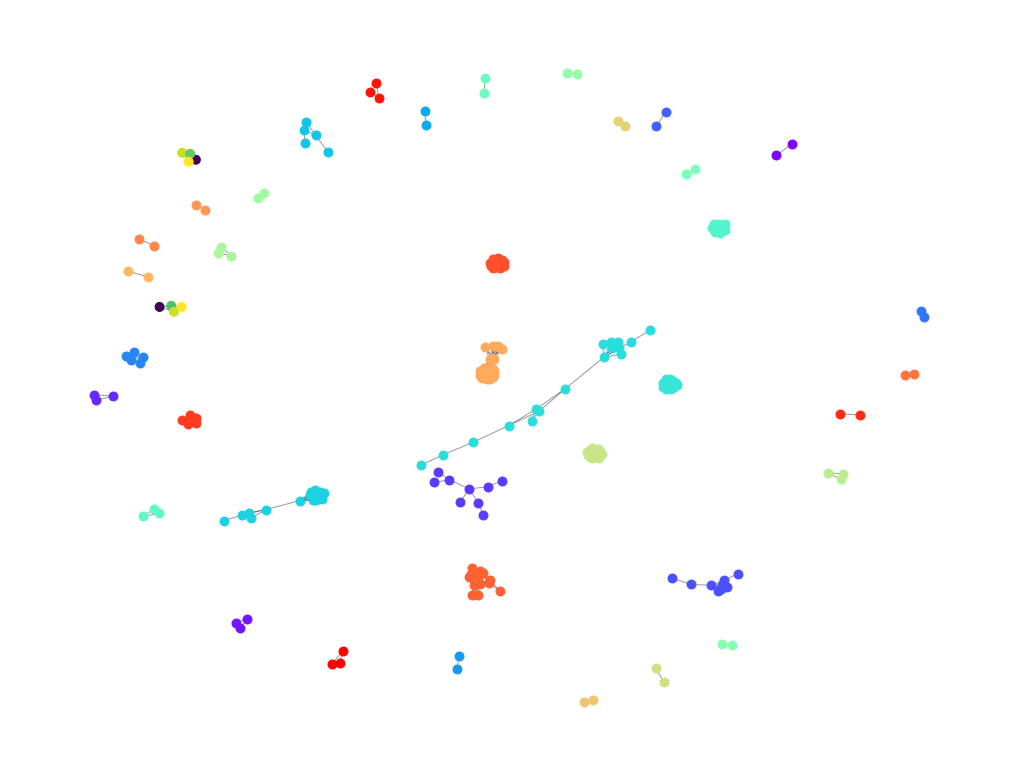

In [21]:
from matplotlib.pyplot import cm
plt.figure(figsize=(18,14))
plt.axis('off')

#drawing
colors = iter(cm.rainbow(np.linspace(0,1,len(set(partition.values())))))
pos = nx.spring_layout(G)
print(colors)
i=0
for com in set(partition.values()):
    color = next(colors)
    list_nodes = [nodo for nodo in partition.keys() if partition[nodo]==com ]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size=80, node_color=color)
    i+=1
nx.draw_networkx_edges(G, pos, alpha=0.4)

In [22]:
comunidades = { c:[] for c in set(partition.values())}

# g1 = community_louvain.induced_graph(partition,G)
# plt.figure(figsize=(20,10))
# nx.draw(G, node_size=20)
for k in partition:
  comunidades[partition[k]]+= [k]
# print(len(comunidades), comunidades)
for c in comunidades:
  print(c, comunidades[c])

0 [1.0, 13.0]
1 [2.0, 3.0, 4.0]
2 [8.0, 10.0, 11.0]
3 [12.0, 333.0, 265.0, 327.0, 328.0, 477.0, 334.0, 337.0, 464.0]
4 [16.0, 17.0, 18.0, 20.0, 28.0, 31.0, 39.0, 22.0, 32.0]
5 [21.0, 34.0]
6 [24.0, 421.0]
7 [30.0, 301.0, 343.0, 352.0, 391.0]
8 [45.0, 94.0]
9 [48.0, 55.0]
10 [53.0, 67.0, 70.0, 72.0]
11 [59.0, 76.0, 96.0, 74.0, 84.0]
12 [69.0, 98.0, 101.0, 102.0, 103.0, 104.0, 130.0, 133.0, 137.0, 138.0, 145.0, 299.0, 123.0, 134.0, 136.0, 143.0, 129.0]
13 [79.0, 113.0, 116.0, 151.0, 81.0, 150.0, 167.0, 106.0, 110.0, 111.0, 115.0, 170.0, 171.0, 155.0, 161.0, 168.0, 173.0]
14 [80.0, 82.0, 83.0, 105.0, 126.0, 152.0, 156.0, 160.0, 163.0, 164.0, 166.0, 169.0, 175.0]
15 [467.0, 472.0, 473.0, 476.0]
16 [91.0, 122.0, 146.0, 147.0, 177.0, 178.0, 179.0, 184.0, 185.0]
17 [93.0, 127.0, 186.0]
18 [95.0, 99.0]
19 [114.0, 174.0]
20 [119.0, 158.0]
21 [139.0, 188.0]
22 [182.0, 187.0]
23 [197.0, 199.0, 200.0]
24 [204.0, 223.0, 224.0]
25 [211.0, 214.0, 215.0, 216.0, 217.0, 218.0, 220.0, 221.0, 222.0, 225.0

In [23]:
com_final = pd.DataFrame()
com_final = pd.DataFrame(columns = ['comunidad', 'nodo_grado_mayor', 'grado', 'nodos','opinion_serie','opinion_real'])


for c in comunidades:   
    grado =-1
    nodo_grado_mayor = -1    
    for nodo in comunidades[c]:
        if(len(tweet.loc[tweet.index==nodo])!=0):
            if G.degree[nodo]>=grado:
                nodo_grado_mayor = nodo
                grado =G.degree[nodo]
    com_final = com_final.append({'comunidad' : c, 'nodo_grado_mayor' : nodo_grado_mayor, 'grado' : grado,
        'nodos': comunidades[c], 'opinion_serie':tweet.iloc[tweet.index==nodo_grado_mayor],'opinion_real': df.loc[nodo_grado_mayor,'obs']        
        }, ignore_index = True)
print(com_final.shape)
com_final.head(20)

(40, 6)


,comunidad,nodo_grado_mayor,grado,nodos,opinion_serie,opinion_real
0,0,13.0,1,"[1.0, 13.0]",13 asignó estudiante tableta entregó estudi...,Se le asignó al estudiante la tableta pero tod...
1,1,4.0,2,"[2.0, 3.0, 4.0]",4 madre vive anexo actualización dni pandem...,La madre vive en Anexo y no pudo realizar actu...
2,2,11.0,2,"[8.0, 10.0, 11.0]",11 madre vive cabaña estudiante dni iletrad...,"La madre vive en la cabaña con la Estudiante, ..."
3,3,327.0,4,"[12.0, 333.0, 265.0, 327.0, 328.0, 477.0, 334....",327 asigno cargador solar estudiante Name: ...,SE LE ASIGNO EL CODIGO DE CARGADOR SOLAR DEL E...
4,4,39.0,6,"[16.0, 17.0, 18.0, 20.0, 28.0, 31.0, 39.0, 22....",39 equipo chips defectuoso par subir archiv...,El equipo no cuenta con chips y es defectuoso ...
5,5,34.0,1,"[21.0, 34.0]",34 tableta asignada figura lista Name: orac...,La tableta asignada es HGAK4KPO el cual no fig...
6,6,421.0,1,"[24.0, 421.0]",421 sistema permitir validar documento dni ...,el sistema no permite validar documentos: DNI ...
7,7,352.0,4,"[30.0, 301.0, 343.0, 352.0, 391.0]",352 to grado to grado Name: oracion_corregi...,"2020 5TO GRADO ,2021 6TO GRADO"
8,8,94.0,1,"[45.0, 94.0]",94 asigna docente cuarto grado tableta estu...,se asigna al docente de cuarto grado la tablet...
9,9,55.0,1,"[48.0, 55.0]",55 cambio apoderado ficha control dni padre...,SE CAMBIO DE APODERADO EN LA FICAH DE CONTROL;...


In [32]:
def get_comunidad_oraciones( nodo_mayor):
    index = com_final[com_final["nodo_grado_mayor"]==nodo_mayor]["nodos"].index[0]
    nodos = com_final[com_final["nodo_grado_mayor"]==nodo_mayor]["nodos"][index]
    for n in nodos:        
        print(n)
        print(df.loc[n,"obs"])
        #print( "Nodo:",n," ",tweet.iloc[tweet.index==n], df.loc[n,'obs'])

get_comunidad_oraciones(116.0)

79.0
Recepciono la madre de familia Sra. Pilar Condori  Huaman DNI 48331838
113.0
Recepciono la madre de familia Sra. Elva Cruz Huaman DNI 45146546
116.0
Recepciono la madre de familia Sra. Marisol Quispe Huaman DNI 47101439
151.0
Recepciono la madre de familia Sra. Justina Achahui  DNI 09518572
81.0
Recepciono su hermano Sr. Cristian Quispe Yucra DNI 63346389
150.0
Recepciono el hermano del estudiante  Sr. Alex Condori Quispe DNI 76773904
167.0
Recepciono el apoderado Sr. Domingo Yucra Condori DNI 42237888
106.0
Recepciono la apoderada Sra. Damiana Quispe Perez DNI 45291622
110.0
Recepciono la apoderada Sra. Magnolia Quispe Luna DNI 73365433
111.0
Recepciono la madre de familia Sra. Luz Marina Quispe Condori DNI 42731065
115.0
Recepciono el padre de familia Sr. Domingo Yucra Condori DNI 42237888
170.0
Recepciono el padre de familia Sr. Jesus Condori Diaz DNI 24687403
171.0
Recepciono el padre de familia Sr. Andres Cusihuayta Condori
155.0
Recepciono el padre de familia Samuel Yupanqui

In [ ]:
#Calculando Page Rank
#====================

import operator
#Nodos mas importantes a nivel de todo el grafo, no necesariamente dentro de la comunidad.
pr = nx.pagerank(G)
sorttt = sorted(pr.items(), key=operator.itemgetter(1), reverse=True)
print(sorttt[:len(set(partition.values()))])

[(116.0, 0.019157867213355752), (151.0, 0.015992246732965454), (136.0, 0.014765551062992476), (67.0, 0.013335849542277615), (197.0, 0.013255792399546575), (76.0, 0.013201160536170247), (96.0, 0.013201160536170247), (170.0, 0.012944027139217188), (171.0, 0.012944027139217188), (16.0, 0.011173350745227831), (32.0, 0.011173350745227831), (134.0, 0.010969178344993589), (39.0, 0.010872103800226712), (115.0, 0.010569403639153823), (80.0, 0.009178519892805605), (82.0, 0.009178519892805605), (83.0, 0.009178519892805605), (105.0, 0.009178519892805605), (126.0, 0.009178519892805605), (152.0, 0.009178519892805605), (156.0, 0.009178519892805605), (160.0, 0.009178519892805605), (163.0, 0.009178519892805605), (164.0, 0.009178519892805605), (169.0, 0.009178519892805605)]


In [33]:
from cdlib import algorithms
from cdlib import viz
from cdlib import evaluation

#extraemos la cantidad e comunidades del grafo
louvain_com = algorithms.louvain(G)
cantidad_comunidades =  len(louvain_com.communities)
print('La cantidad de comunidades es', len(louvain_com.communities))

# las frases mejor comunicadas
# for c in louvain_com.communities:
#   print(c)

Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'graph_tool', 'leidenalg', 'infomap', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'infomap'}
La cantidad de comunidades es 40


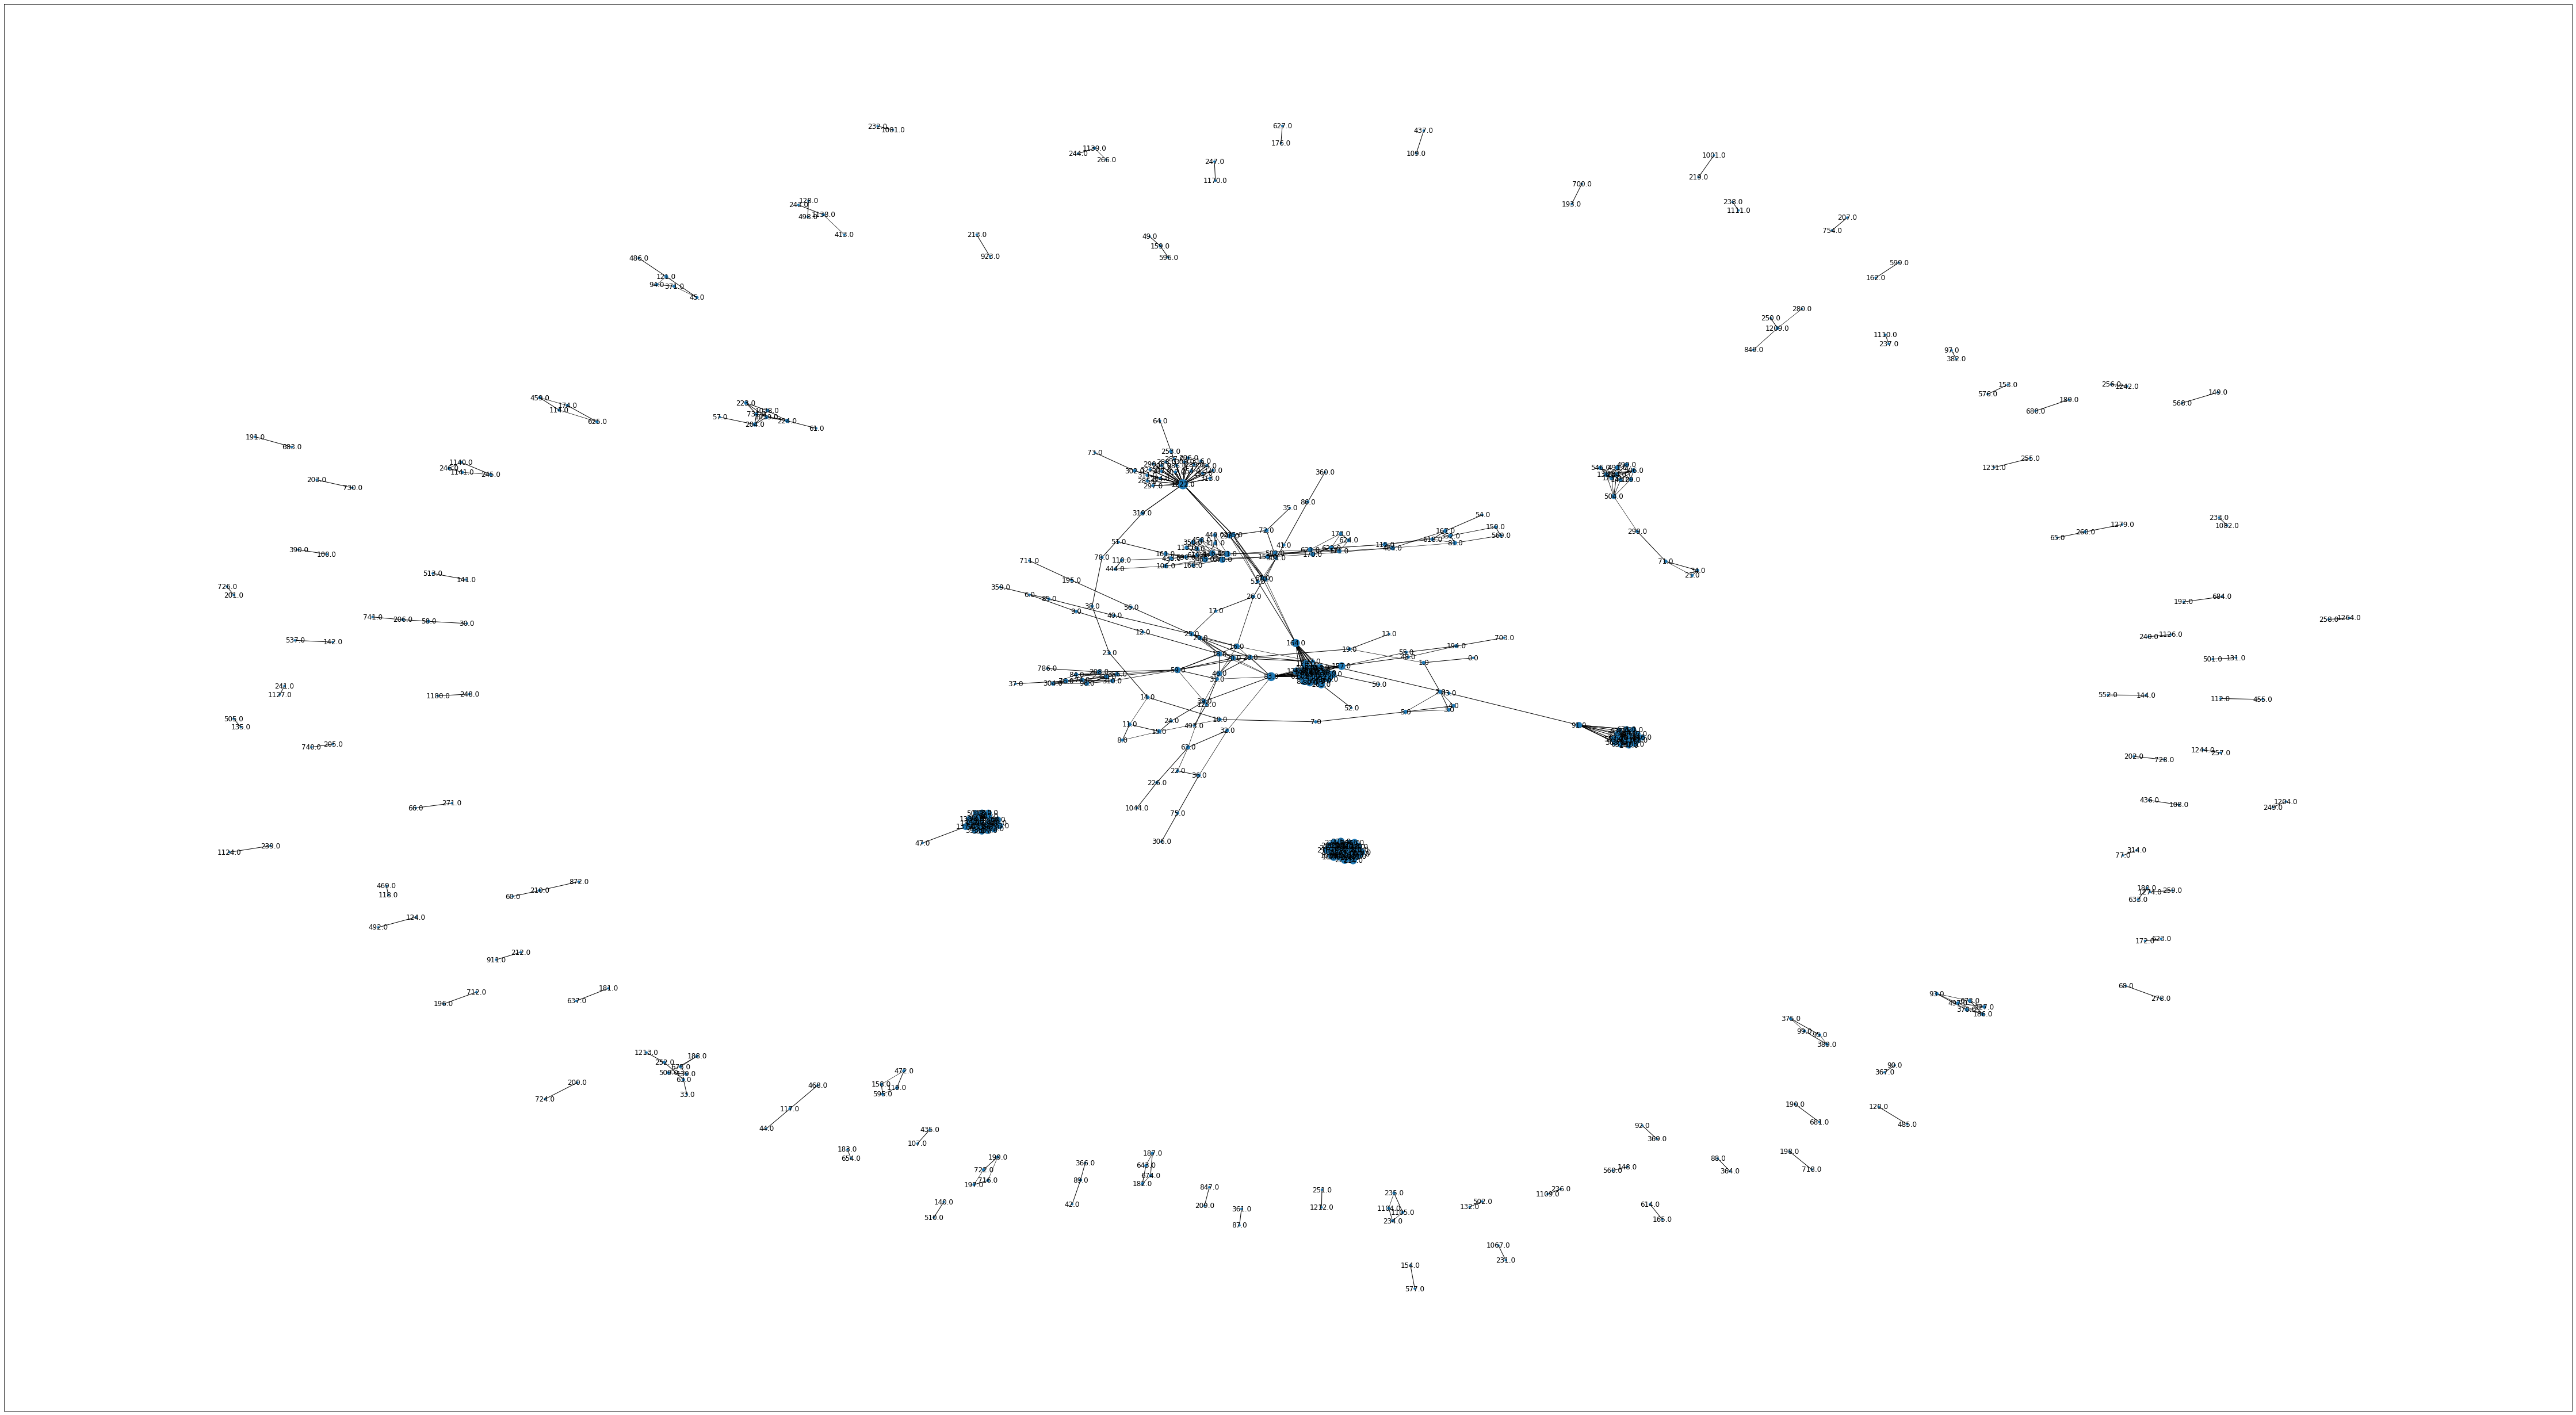

In [ ]:
#Diagrama de todos los nodos interconectados (Spanning Trees)
#============================================================
gdeg = G.degree()
plt.figure(figsize=(80,45)) 
pos=nx.spring_layout(G)
edges = G.edges()
weights = [G[u][v]['peso'] for u,v in edges]
nx.draw_networkx(G, width=weights, pos=pos, node_size=[val*10 for(node,val)in gdeg])
plt.show()

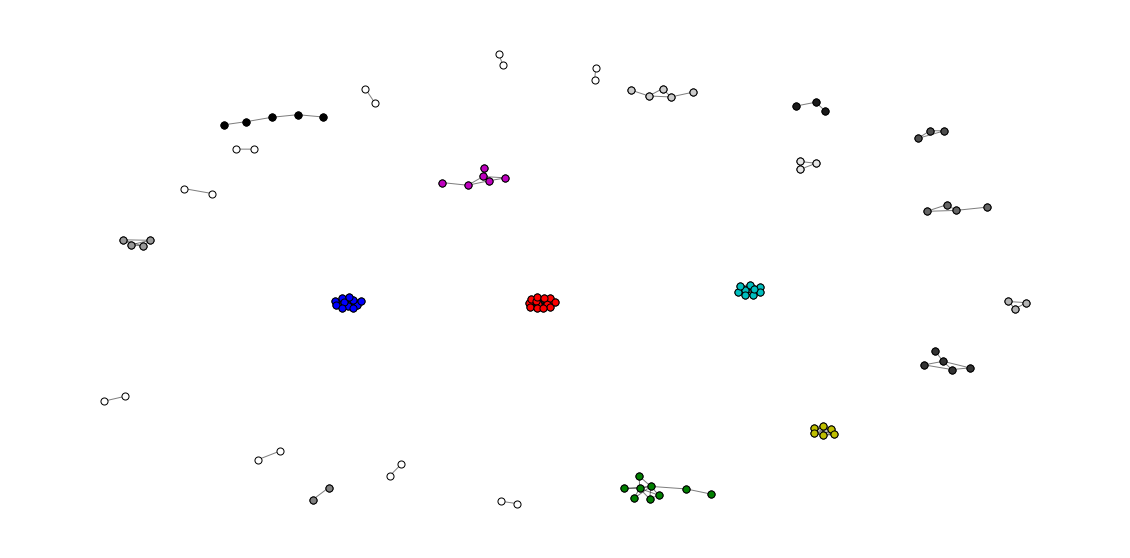

In [ ]:
viz.plot_network_clusters(G, louvain_com, node_size=50, figsize=(20,10), top_k=len(louvain_com.communities))

In [ ]:
# las frases mejor comunicadas
for c in louvain_com.communities:
  print(c)

[80.0, 82.0, 83.0, 105.0, 126.0, 152.0, 156.0, 157.0, 160.0, 163.0, 164.0, 166.0, 169.0, 175.0]
[69.0, 98.0, 101.0, 102.0, 103.0, 104.0, 130.0, 133.0, 137.0, 138.0, 145.0]
[79.0, 113.0, 116.0, 151.0, 106.0, 110.0, 111.0, 161.0, 168.0]
[91.0, 122.0, 146.0, 147.0, 177.0, 178.0, 179.0, 184.0, 185.0]
[115.0, 167.0, 170.0, 171.0, 155.0, 173.0]
[211.0, 214.0, 215.0, 216.0, 217.0, 218.0]
[16.0, 17.0, 39.0, 22.0, 32.0]
[59.0, 76.0, 96.0, 74.0, 84.0]
[123.0, 134.0, 136.0, 129.0, 143.0]
[18.0, 20.0, 28.0, 31.0]
[53.0, 67.0, 70.0, 72.0]
[2.0, 3.0, 4.0]
[8.0, 10.0, 11.0]
[93.0, 127.0, 186.0]
[197.0, 199.0, 200.0]
[1.0, 13.0]
[21.0, 34.0]
[45.0, 94.0]
[48.0, 55.0]
[81.0, 150.0]
[85.0, 141.0]
[95.0, 99.0]
[114.0, 174.0]
[119.0, 158.0]
[139.0, 188.0]


#Metricas de calidad del grafo en la deteccion de comunidades REVISAR!!!
#Recomendaciones probar con el algoritmo de Leiden
#CDLib
#https://colab.research.google.com/github/GiulioRossetti/cdlib/blob/master/docs/CDlib.ipynb#scrollTo=tT3kyTr44bqz